<a href="https://colab.research.google.com/github/poojamahajan0712/EVA_Pooja/blob/master/EVA_S6_Step1(Sample).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [132]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


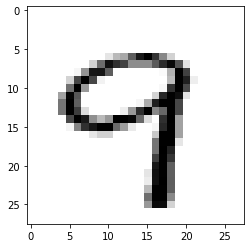

In [133]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

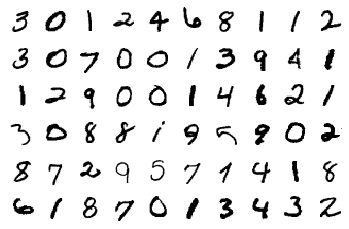

In [134]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26  Rf 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),  #32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    #32
            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF 6 Jout - 2


        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size =10  RF 10 Jout - 2


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8  RF -14 ,Jout - 2

        #self.convblock6 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #   nn.ReLU(),
        #   nn.BatchNorm2d(16),
        #   nn.Dropout(dropout_value)
        #) # output_size = 6 RF - 18  Jout - 2

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
       # x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [136]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch,is_L1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    ##Adding code for L1 Regularisation
    if(is_L1==True):
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
          reg_loss += l1_crit(param,target=torch.zeros_like(param))

      factor = 0.0005
      loss += factor * reg_loss
      train_losses.append(loss)

    else:
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #return(test_acc,test_loss)

# Let's Train and test our model

In [138]:
def train_model(is_L1,is_L2):
  model =  Net().to(device)
  
  if(is_L2==True):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 6
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,is_L1)
      test(model, device, test_loader)
  
  #return(test_acc,test_losses)

train_model(is_L1=False,is_L2=False)
train_model(is_L1=True,is_L2=False)
train_model(is_L1=False,is_L2=True)
train_model(is_L1=True,is_L2=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.23734039068222046 Batch_id=468 Accuracy=85.09: 100%|██████████| 469/469 [00:11<00:00, 47.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1971, Accuracy: 9490/10000 (94.90%)

EPOCH: 1


Loss=0.0893164873123169 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9749/10000 (97.49%)

EPOCH: 2


Loss=0.058399949222803116 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9835/10000 (98.35%)

EPOCH: 3


Loss=0.14787276089191437 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9746/10000 (97.46%)

EPOCH: 4


Loss=0.023675626143813133 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.038835231214761734 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9826/10000 (98.26%)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.375225305557251 Batch_id=468 Accuracy=83.78: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1829, Accuracy: 9591/10000 (95.91%)

EPOCH: 1


Loss=0.29262858629226685 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1211, Accuracy: 9717/10000 (97.17%)

EPOCH: 2


Loss=0.25936171412467957 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:12<00:00, 38.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1284, Accuracy: 9652/10000 (96.52%)

EPOCH: 3


Loss=0.2388165295124054 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Accuracy: 9823/10000 (98.23%)

EPOCH: 4


Loss=0.22863316535949707 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0848, Accuracy: 9761/10000 (97.61%)

EPOCH: 5


Loss=0.21892426908016205 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9829/10000 (98.29%)

EPOCH: 0


Loss=0.17776864767074585 Batch_id=468 Accuracy=84.50: 100%|██████████| 469/469 [00:11<00:00, 48.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1964, Accuracy: 9579/10000 (95.79%)

EPOCH: 1


Loss=0.10810208320617676 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:11<00:00, 41.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1252, Accuracy: 9734/10000 (97.34%)

EPOCH: 2


Loss=0.09620901197195053 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:11<00:00, 41.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.09487471729516983 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:11<00:00, 41.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1037, Accuracy: 9753/10000 (97.53%)

EPOCH: 4


Loss=0.054073452949523926 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 41.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1099, Accuracy: 9754/10000 (97.54%)

EPOCH: 5


Loss=0.06824823468923569 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 41.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0811, Accuracy: 9824/10000 (98.24%)

EPOCH: 0


Loss=0.32585060596466064 Batch_id=468 Accuracy=82.88: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2130, Accuracy: 9587/10000 (95.87%)

EPOCH: 1


Loss=0.3271089792251587 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1292, Accuracy: 9728/10000 (97.28%)

EPOCH: 2


Loss=0.24445150792598724 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:11<00:00, 39.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2346, Accuracy: 9331/10000 (93.31%)

EPOCH: 3


Loss=0.2075018286705017 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1992, Accuracy: 9436/10000 (94.36%)

EPOCH: 4


Loss=0.27357298135757446 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1236, Accuracy: 9732/10000 (97.32%)

EPOCH: 5


Loss=0.18233607709407806 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]



Test set: Average loss: 0.1013, Accuracy: 9790/10000 (97.90%)



Text(0.5, 1.0, 'Test Accuracy')

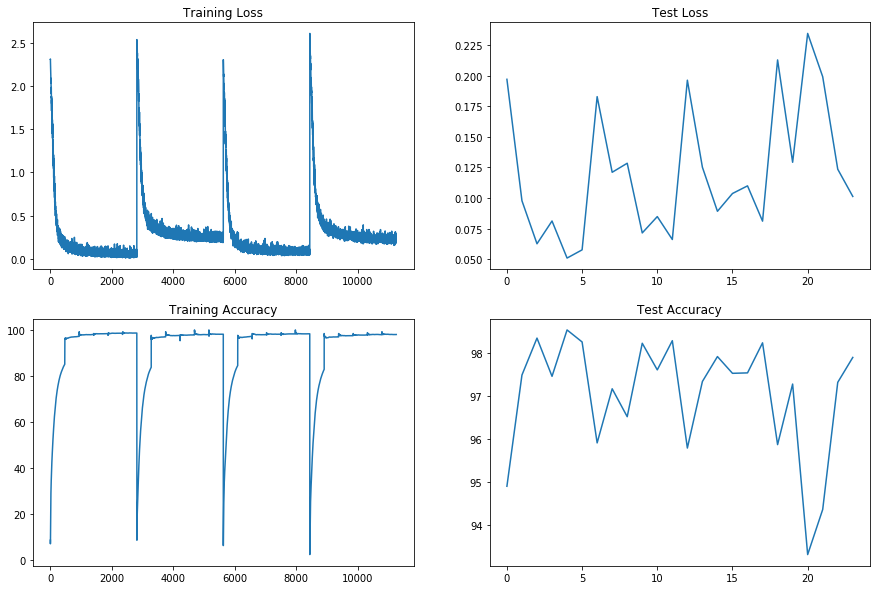

In [139]:
#fig, axs = plt.subplots(2,2,figsize=(15,10))
#axs[0, 0].plot(train_losses)
#axs[0, 0].set_title("Training Loss")
#axs[1, 0].plot(train_acc)
#axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")

In [140]:
print((test_acc))
print((test_losses))

[94.9, 97.49, 98.35, 97.46, 98.54, 98.26, 95.91, 97.17, 96.52, 98.23, 97.61, 98.29, 95.79, 97.34, 97.92, 97.53, 97.54, 98.24, 95.87, 97.28, 93.31, 94.36, 97.32, 97.9]
[0.19710210373401643, 0.09775895824432373, 0.06257047624588012, 0.08119858071804047, 0.05088390433788299, 0.05759782474040985, 0.1829251223087311, 0.12105747818946838, 0.12844815845489502, 0.07145276880264283, 0.08480131607055665, 0.06606724367141724, 0.19638287663459777, 0.12518145666122438, 0.0891346265077591, 0.10368956158161163, 0.10994026465415954, 0.08107318091392517, 0.21295935962200166, 0.12923909125328065, 0.23463212769031525, 0.19920701971054078, 0.12355900015830994, 0.10128132309913636]


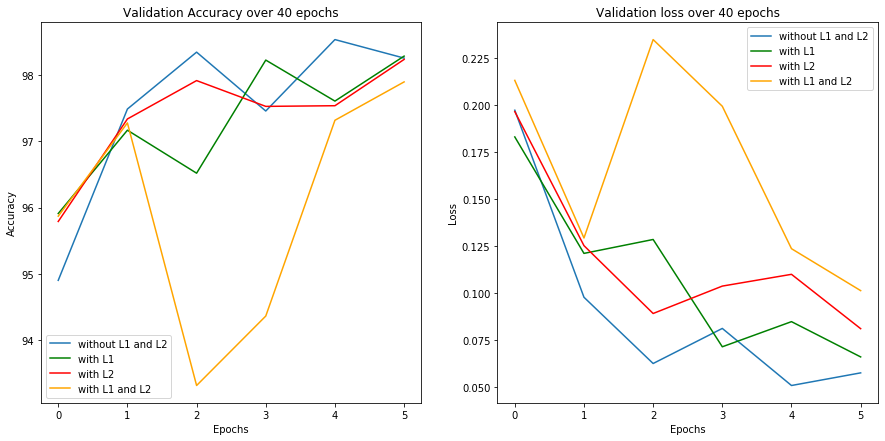

In [160]:
from google.colab import files


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(test_acc[:6], label="without L1 and L2")
ax1.plot(test_acc[6:12], color="green", label="with L1")
ax1.plot(test_acc[12:18], color="red", label="with L2")
ax1.plot(test_acc[18:], color="orange", label="with L1 and L2")
ax1.set_title("Validation Accuracy over 40 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Accuracy.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Accuracy.png") 

ax2.plot(test_losses[:6],label="without L1 and L2")
ax2.plot(test_losses[6:12], color="green", label="with L1")
ax2.plot(test_losses[12:18], color="red", label="with L2")
ax2.plot(test_losses[18:], color="orange", label="with L1 and L2")
ax2.set_title("Validation loss over 40 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Loss.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Loss.png") 